In [1]:
using Revise
using ProgressMeter
using LinearAlgebra
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
using ForneyLab
import ForneyLab: unsafeMean, unsafeCov
using ARMA

┌ Info: Precompiling ARMA [d0fcd768-fc94-4312-accc-38bd200d922b]
└ @ Base loading.jl:1278


## Data generation

In [3]:
# Parameters
θ_true = [0.2, 0.1]
η_true = [0.8, -.2]
τ_true = 10.

# Orders
M1 = length(θ_true)
M2 = length(η_true)

# Time horizon
T = 100

# Observation array
output = zeros(T,)
errors = zeros(T,)

# First 2 outputs
output[1] = 0.0
output[2] = 0.0

for k = max(M1,M2)+1:T
    
    # Errors
    errors[k] = sqrt(inv(τ_true))*randn(1)[1]
   
    # ARMA
    output[k] = θ_true'*output[k-1:-1:k-M1] + η_true'*errors[k-1:-1:k-M2] + errors[k]

end

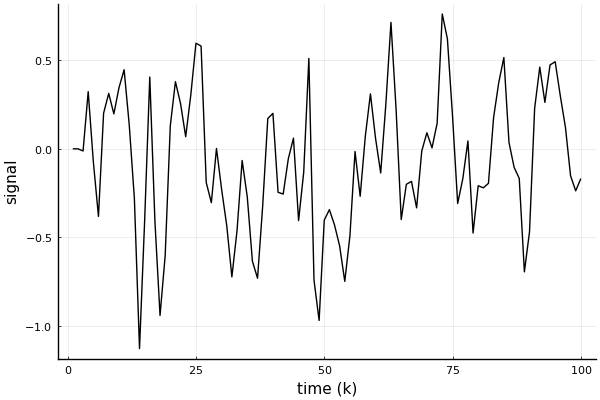

In [4]:
plot(1:T, output, color="black", label="", xlabel="time (k)", ylabel="signal")

## Model specification

In [5]:
graph = FactorGraph()

# Observed variables
@RV z_kmin1; placeholder(z_kmin1, :z_kmin1, dims=(M1,))
@RV r_kmin1; placeholder(r_kmin1, :r_kmin1, dims=(M2,))

# Time-invariant parameters
@RV θ ~ GaussianMeanVariance(placeholder(:m_θ, dims=(M1+M2,)), placeholder(:v_θ, dims=(M1+M2, M1+M2)))
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))

# Likel7ihood
@RV y_k ~ AutoRegressiveMovingAverage(θ, z_kmin1, r_kmin1, τ)
placeholder(y_k, :y_k)

ForneyLab.draw(graph)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 14493758292311114628 -->
 
 14493758292311114628 
 
 placeholder_a_τ 
 
<!-- 7993778956916933713 -->
 
 7993778956916933713 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 4875482158646678724 -->
 
 4875482158646678724 
 
 placeholder_m_θ 
 
<!-- 7993778956916933713--4875482158646678724 -->
 
 7993778956916933713--4875482158646678724 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 7477686534644228523 -->
 
 7477686534644228523 
 
 placeholder_v_θ 
 
<!-- 7993778956916933713--7477686534644228523 -->
 
 7993778956916933713--7477686534644228523 
 
 v_θ 
 1 out 
 3 v 
 
<!-- 16293047849415335115 -->
 
 16293047849415335115 
 
 placeholder_r_kmin1 
 
<!-- 16377949931888529844 -->
 
 16377949931888529844 
 
 placeholder_z_kmin1 
 
<!-- 17643119532913578290 -->
 
 17643119532913578290 
 
 ARMA 
 autoregressivemovingaverage_1 
 
<!-- 17643119532913578290--7993778956916933713 -->
 
 17643119532913578290--7993778956916933713 
 
 θ 
 1 out 
 2 θ 
 
<!-- 17643119532913578290--16293047849415335115 -->
 
 17643119532913578290--16293047849415335115 
 
 r_kmin1 
 1 out 
 4 r 
 
<!-- 17643119532913578290--16377949931888529844 -->
 
 17643119532913578290--16377949931888529844 
 
 z_kmin1 
 1 out 
 3 z 
 
<!-- 12060705948079729671 -->
 
 12060705948079729671 
 
 Gam 
 gamma_1 
 
<!-- 17643119532913578290--12060705948079729671 -->
 
 17643119532913578290--12060705948079729671 
 
 τ 
 1 out 
 5 τ 
 
<!-- 17501331184507780044 -->
 
 17501331184507780044 
 
 placeholder_b_τ 
 
<!-- 1030979186998400518 -->
 
 1030979186998400518 
 
 placeholder_y_k 
 
<!-- 1030979186998400518--17643119532913578290 -->
 
 1030979186998400518--17643119532913578290 
 
 y_k 
 1 y 
 1 out 
 
<!-- 12060705948079729671--14493758292311114628 -->
 
 12060705948079729671--14493758292311114628 
 
 a_τ 
 1 out 
 2 a 
 
<!-- 12060705948079729671--17501331184507780044 -->
 
 12060705948079729671--17501331184507780044 
 
 b_τ 
 1 out 
 3 b

In [6]:
q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
algorithm = messagePassingAlgorithm([θ; τ], q)
source_code = algorithmSourceCode(algorithm)
eval(Meta.parse(source_code));

In [7]:
# Preallocate parameter arrays
params_θ = (ones(M1+M2,T+1), repeat(Matrix{Float64}(I, M1+M2, M1+M2), outer=(1,1,T+1)))
params_τ = (10 .*ones(T+1,), 1 .*ones(T+1,))

marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=params_θ[1][:,1], v=params_θ[2][:,:,1]),
                 :τ => ProbabilityDistribution(Univariate, Gamma, a=params_τ[1][1], b=params_τ[2][1]))

# Keep track of residuals
predictions = zeros(T+1,)
residuals = zeros(T,)

@showprogress for k = max(M1,M2)+1:T
    
    # Compute residuals
    residuals[k] = output[k] - predictions[k]
    
    # Set data 
    data = Dict(:y_k => output[k],
                :z_kmin1 => output[k-1:-1:k-M1],
                :r_kmin1 => residuals[k-1:-1:k-M2],
                :m_θ => params_θ[1][:,k],
                :v_θ => params_θ[2][:,:,k],
                :a_τ => params_τ[1][k],
                :b_τ => params_τ[2][k])
    
    # Iterate updates
    for n = 1:10
        stepθ!(data, marginals)
        stepτ!(data, marginals)
    end    
    
    # Update params
    params_θ[1][:,k+1] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,k+1] = unsafeCov(marginals[:θ])
    params_τ[1][k+1] = marginals[:τ].params[:a]
    params_τ[2][k+1] = marginals[:τ].params[:b]
    
    # Predictions
    predictions[k+1] = params_θ[1][:,k]'*[output[k-1:-1:k-M1]; residuals[k-1:-1:k-M2]]
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


## Visualization

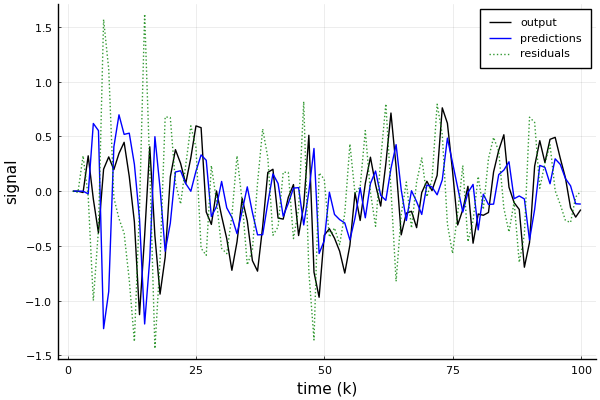

In [8]:
plot(1:T, output, color="black", label="output", xlabel="time (k)", ylabel="signal")
plot!(1:T, predictions[2:end], color="blue", label="predictions")
plot!(1:T, residuals[2:end], color="green", linestyle=:dot, label="residuals", alpha=0.8)

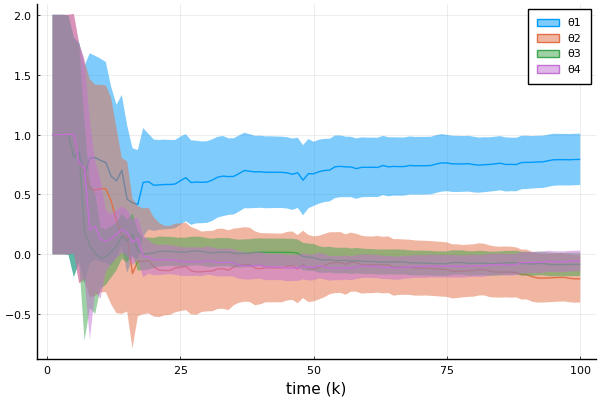

In [9]:
plot(1:T, params_θ[1][1,2:end], ribbon=[params_θ[2][1,1,:] params_θ[2][1,1,:]], xlabel="time (k)", label="θ1")
plot!(1:T, params_θ[1][2,2:end], ribbon=[params_θ[2][2,2,:] params_θ[2][2,2,:]], xlabel="time (k)", label="θ2")
plot!(1:T, params_θ[1][3,2:end], ribbon=[params_θ[2][3,3,:] params_θ[2][3,3,:]], xlabel="time (k)", label="θ3")
plot!(1:T, params_θ[1][4,2:end], ribbon=[params_θ[2][4,4,:] params_θ[2][4,4,:]], xlabel="time (k)", label="θ4")

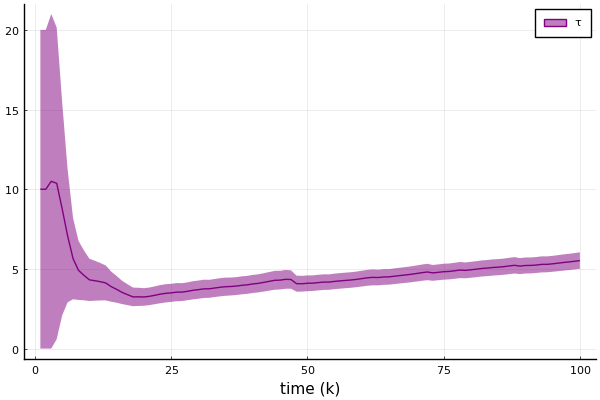

In [10]:
mτ = params_τ[1][2:end] ./ params_τ[2][2:end]
vτ = params_τ[1][2:end] ./ params_τ[2][2:end].^2

plot(1:T, mτ, ribbon=[vτ vτ], color="purple", xlabel="time (k)", label="τ")